In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Import ptdxdt
import ptdxdt

## 1. Generate Test Signal

We'll use a simple sinusoidal signal: $x(t) = \sin(t)$

The analytical derivative is: $\frac{dx}{dt} = \cos(t)$

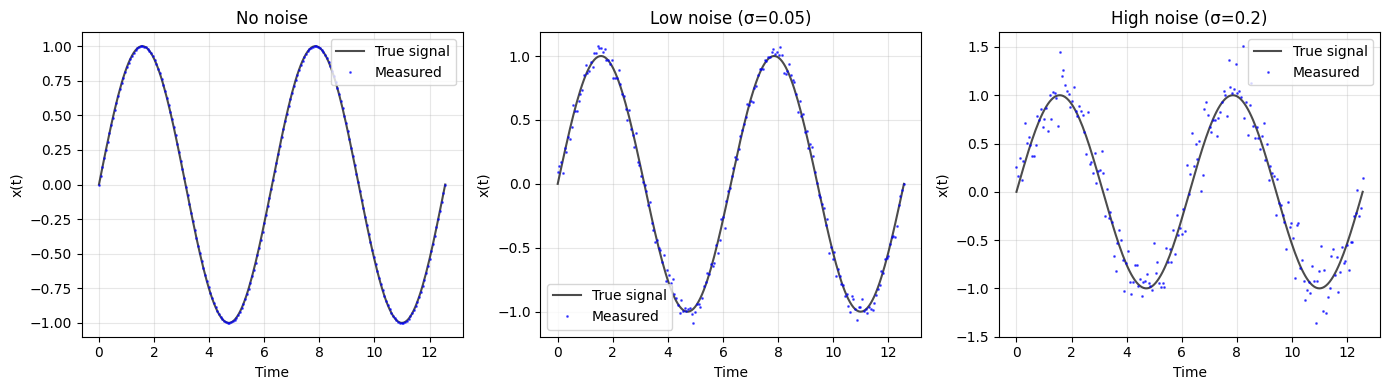

In [2]:
# Time vector
n_points = 200
t = torch.linspace(0, 4 * torch.pi, n_points)

# True signal and derivative
x_true = torch.sin(t)
dx_true = torch.cos(t)

# Different noise levels
noise_levels = {
    "No noise": 0.0,
    "Low noise (σ=0.05)": 0.05,
    "High noise (σ=0.2)": 0.2,
}

# Generate noisy signals
noisy_signals = {}
for name, sigma in noise_levels.items():
    if sigma == 0:
        noisy_signals[name] = x_true.clone()
    else:
        noisy_signals[name] = x_true + sigma * torch.randn_like(x_true)

# Plot the signals
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, (name, x_noisy) in zip(axes, noisy_signals.items()):
    ax.plot(t.numpy(), x_true.numpy(), 'k-', label='True signal', alpha=0.7)
    ax.plot(t.numpy(), x_noisy.numpy(), 'b.', markersize=2, label='Measured', alpha=0.6)
    ax.set_xlabel('Time')
    ax.set_ylabel('x(t)')
    ax.set_title(name)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Define All Methods

We'll compare all seven differentiation methods available in `ptdxdt`:

In [3]:
# Define all methods with reasonable parameters
methods = {
    "Finite Difference (k=1)": ptdxdt.FiniteDifference(k=1),
    "Finite Difference (k=2)": ptdxdt.FiniteDifference(k=2),
    "Savitzky-Golay": ptdxdt.SavitzkyGolay(window_length=11, polyorder=3),
    "Spectral": ptdxdt.Spectral(),
    "Spline (s=0.01)": ptdxdt.Spline(s=0.01),
    "Kernel (GP)": ptdxdt.Kernel(sigma=0.5, lmbd=0.01),
    "Kalman": ptdxdt.Kalman(alpha=0.5),
    "Whittaker": ptdxdt.Whittaker(lmbda=100.0),
}

print(f"Comparing {len(methods)} differentiation methods")

Comparing 8 differentiation methods


## 3. Compare Methods Across Noise Levels

Let's compute derivatives using each method for each noise level and visualize the results:

In [4]:
def compute_derivatives(methods, x, t):
    """Compute derivatives using all methods."""
    results = {}
    for name, method in methods.items():
        try:
            dx = method.d(x, t)
            results[name] = dx
        except Exception as e:
            print(f"Error with {name}: {e}")
            results[name] = None
    return results

def compute_rmse(dx_pred, dx_true):
    """Compute RMSE between predicted and true derivative."""
    if dx_pred is None:
        return float('inf')
    return torch.sqrt(torch.mean((dx_pred - dx_true) ** 2)).item()

# Compute derivatives for all noise levels
all_results = {}
for noise_name, x_noisy in noisy_signals.items():
    all_results[noise_name] = compute_derivatives(methods, x_noisy, t)

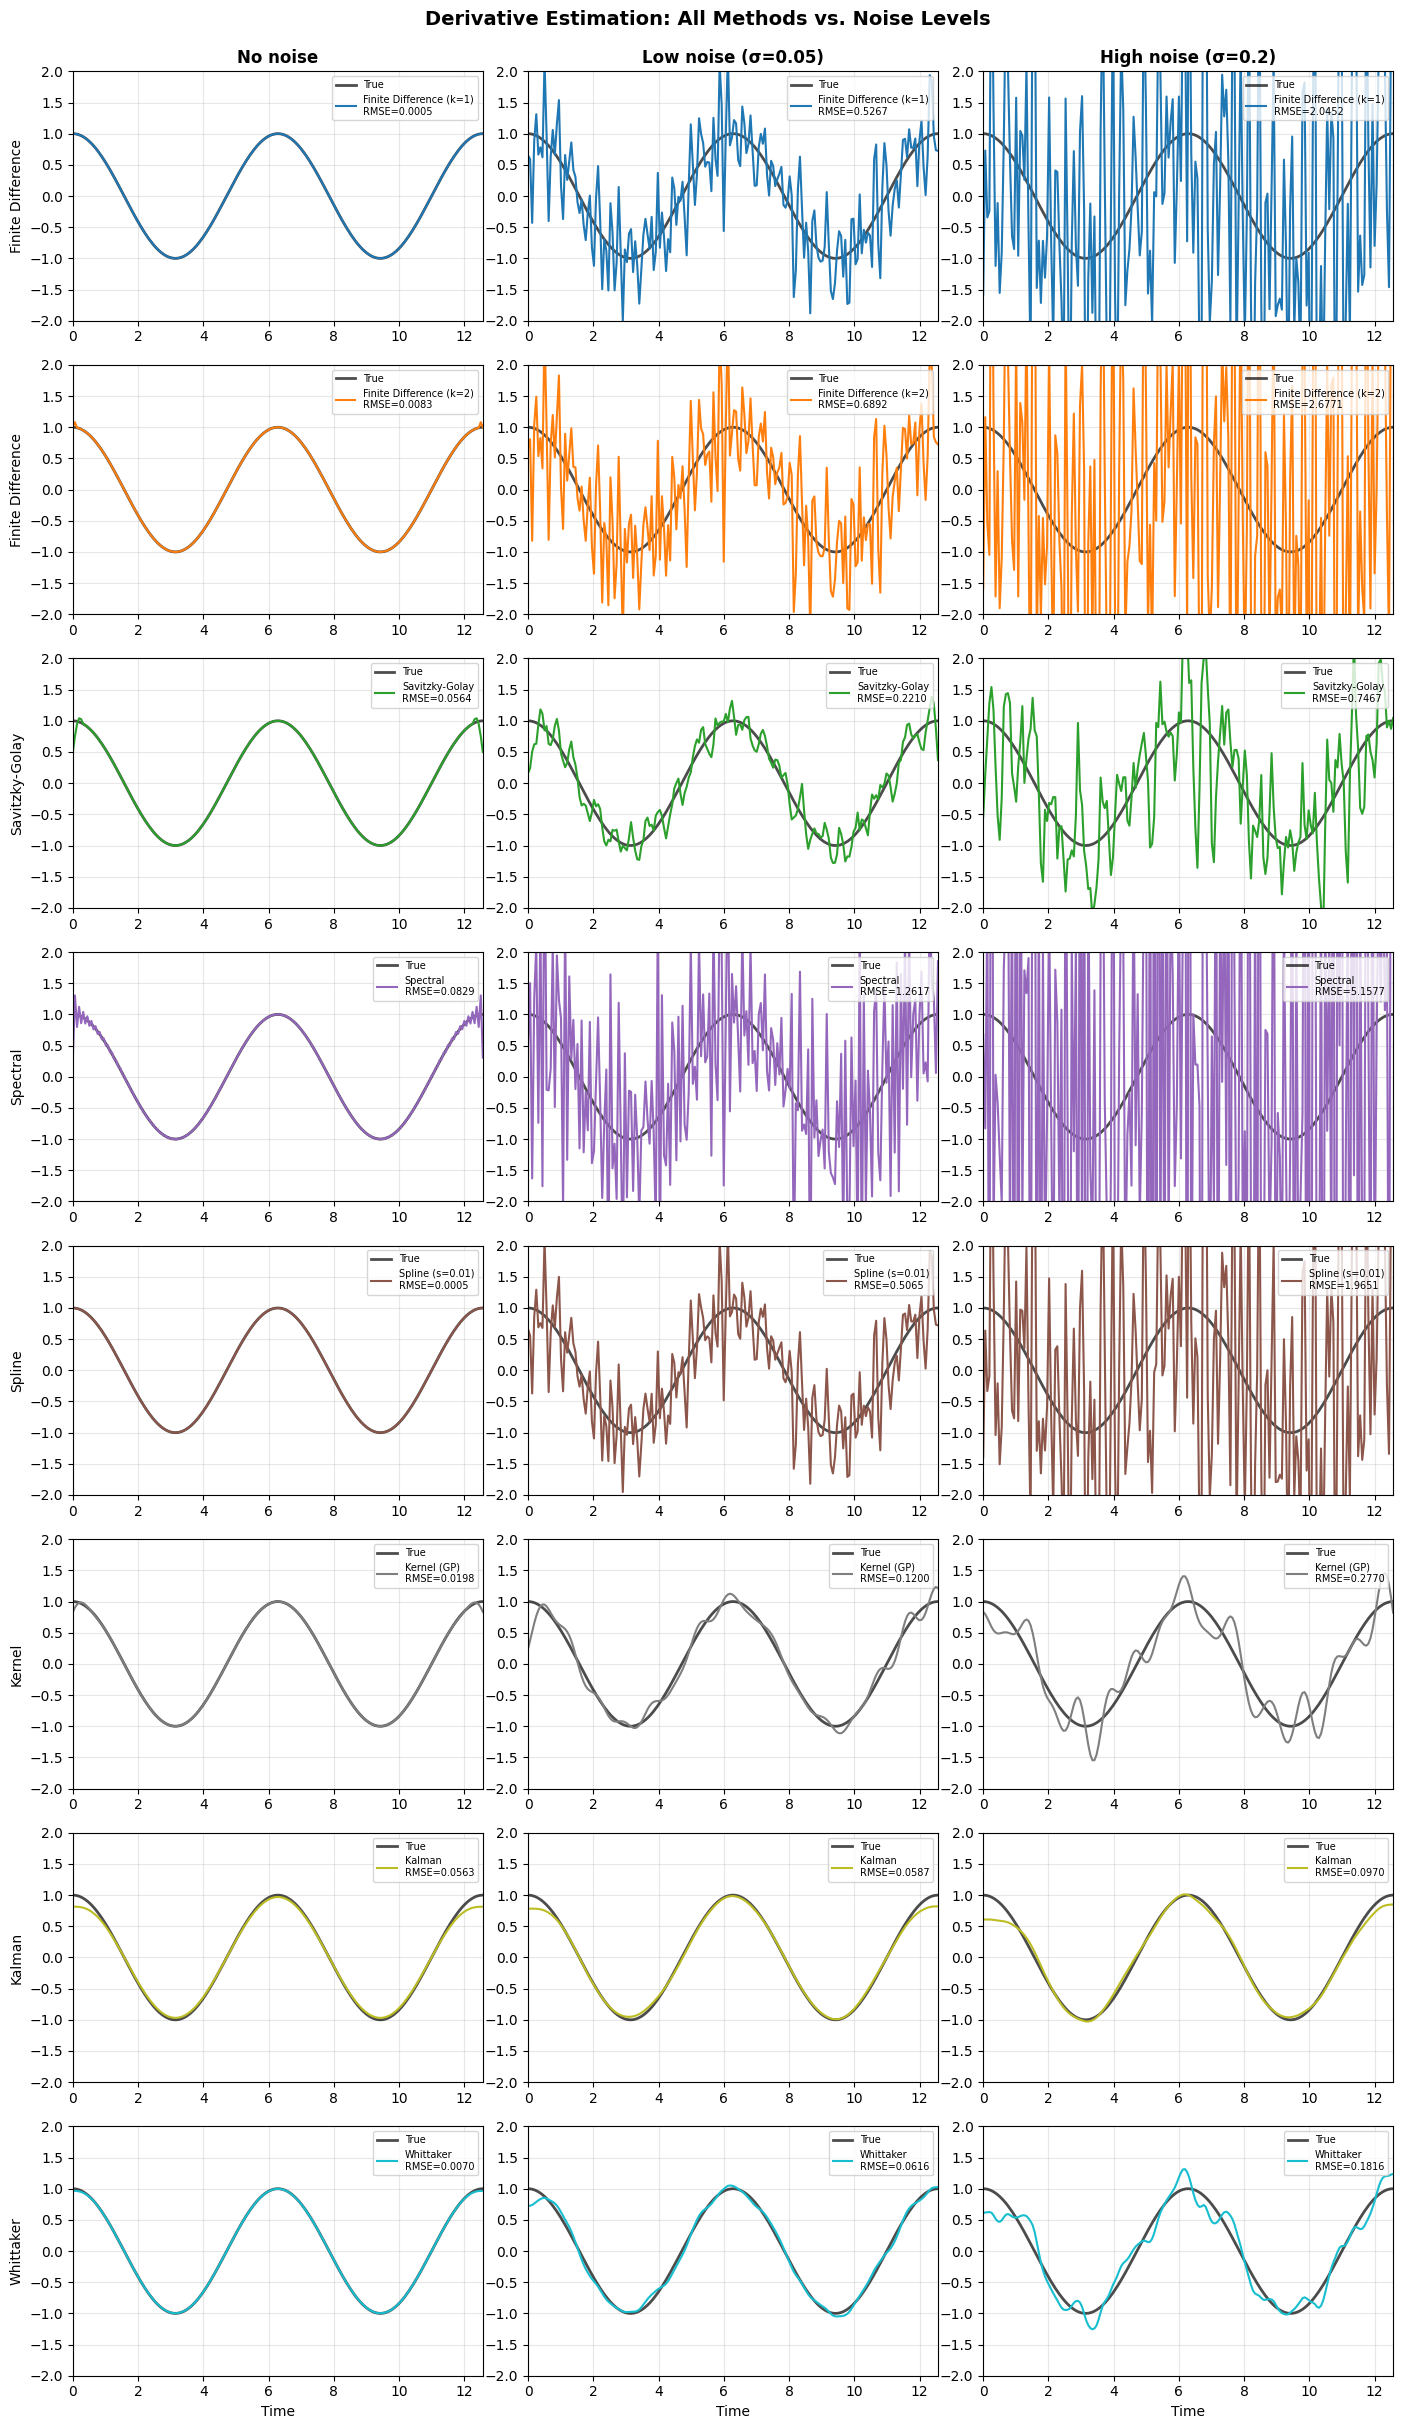

In [5]:
# Create a large comparison plot
n_methods = len(methods)
n_noise = len(noise_levels)

fig, axes = plt.subplots(n_methods, n_noise, figsize=(14, 3 * n_methods))

colors = plt.cm.tab10(np.linspace(0, 1, n_methods))

for j, (noise_name, results) in enumerate(all_results.items()):
    for i, (method_name, dx) in enumerate(results.items()):
        ax = axes[i, j]
        
        # Plot true derivative
        ax.plot(t.numpy(), dx_true.numpy(), 'k-', linewidth=2, label='True', alpha=0.7)
        
        # Plot computed derivative
        if dx is not None:
            rmse = compute_rmse(dx, dx_true)
            ax.plot(t.numpy(), dx.numpy(), color=colors[i], linewidth=1.5, 
                    label=f'{method_name}\nRMSE={rmse:.4f}')
        else:
            ax.text(0.5, 0.5, 'Failed', transform=ax.transAxes, ha='center')
        
        ax.set_xlim(t[0].item(), t[-1].item())
        ax.set_ylim(-2, 2)
        ax.grid(True, alpha=0.3)
        
        if i == 0:
            ax.set_title(noise_name, fontsize=12, fontweight='bold')
        if j == 0:
            ax.set_ylabel(method_name.split('(')[0].strip(), fontsize=10)
        if i == n_methods - 1:
            ax.set_xlabel('Time')
        
        ax.legend(loc='upper right', fontsize=7)

plt.tight_layout()
plt.suptitle('Derivative Estimation: All Methods vs. Noise Levels', 
             fontsize=14, fontweight='bold', y=1.01)
plt.show()

## 4. Quantitative Comparison (RMSE)

Let's create a summary table of RMSE values for each method and noise level:

In [6]:
# Compute RMSE for all combinations
rmse_table = {}
for noise_name, results in all_results.items():
    rmse_table[noise_name] = {}
    for method_name, dx in results.items():
        rmse_table[noise_name][method_name] = compute_rmse(dx, dx_true)

# Display as a formatted table
print("\n" + "="*80)
print("RMSE Comparison Table")
print("="*80)

# Header
header = f"{'Method':<30}"
for noise_name in noise_levels.keys():
    header += f"{noise_name:<20}"
print(header)
print("-"*80)

# Rows
for method_name in methods.keys():
    row = f"{method_name:<30}"
    for noise_name in noise_levels.keys():
        rmse = rmse_table[noise_name][method_name]
        row += f"{rmse:<20.6f}"
    print(row)

print("="*80)


RMSE Comparison Table
Method                        No noise            Low noise (σ=0.05)  High noise (σ=0.2)  
--------------------------------------------------------------------------------
Finite Difference (k=1)       0.000471            0.526654            2.045237            
Finite Difference (k=2)       0.008328            0.689206            2.677069            
Savitzky-Golay                0.056397            0.221014            0.746678            
Spectral                      0.082896            1.261733            5.157719            
Spline (s=0.01)               0.000472            0.506474            1.965082            
Kernel (GP)                   0.019842            0.119996            0.276995            
Kalman                        0.056285            0.058744            0.097021            
Whittaker                     0.007004            0.061624            0.181598            


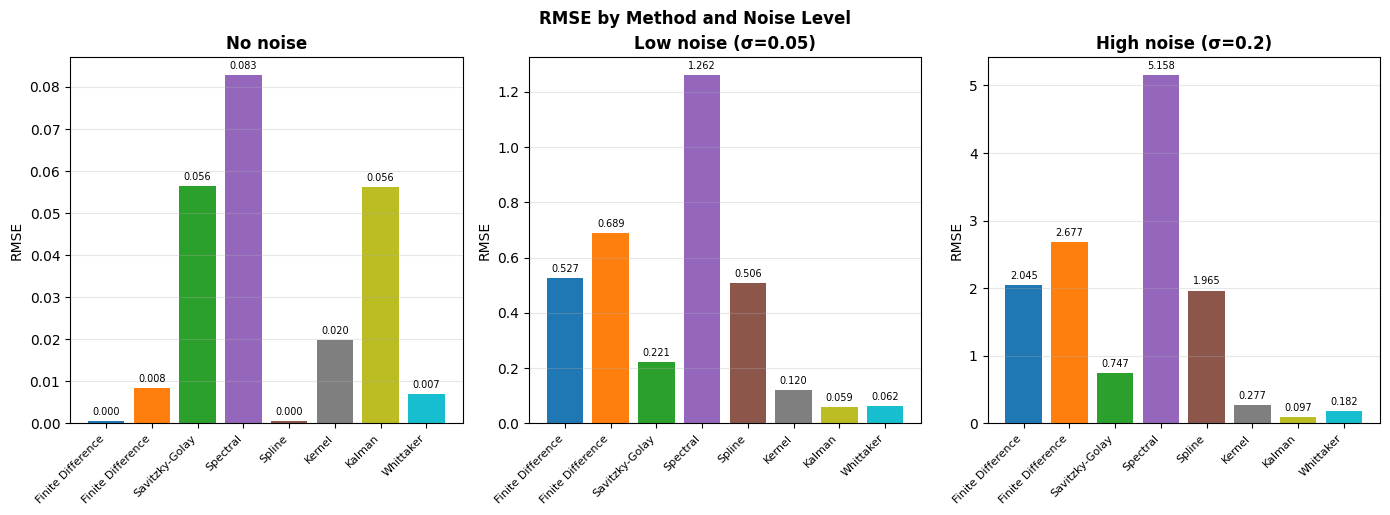

In [7]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

method_names = list(methods.keys())
x_pos = np.arange(len(method_names))

for ax, (noise_name, rmses) in zip(axes, rmse_table.items()):
    values = [rmses[m] for m in method_names]
    bars = ax.bar(x_pos, values, color=colors)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([m.split('(')[0].strip() for m in method_names], 
                        rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('RMSE')
    ax.set_title(noise_name, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{val:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.suptitle('RMSE by Method and Noise Level', fontsize=12, fontweight='bold', y=1.02)
plt.show()

## 5. Detailed Analysis: Best Methods for Noisy Data

Let's focus on the high-noise case and tune some methods to see their best performance:

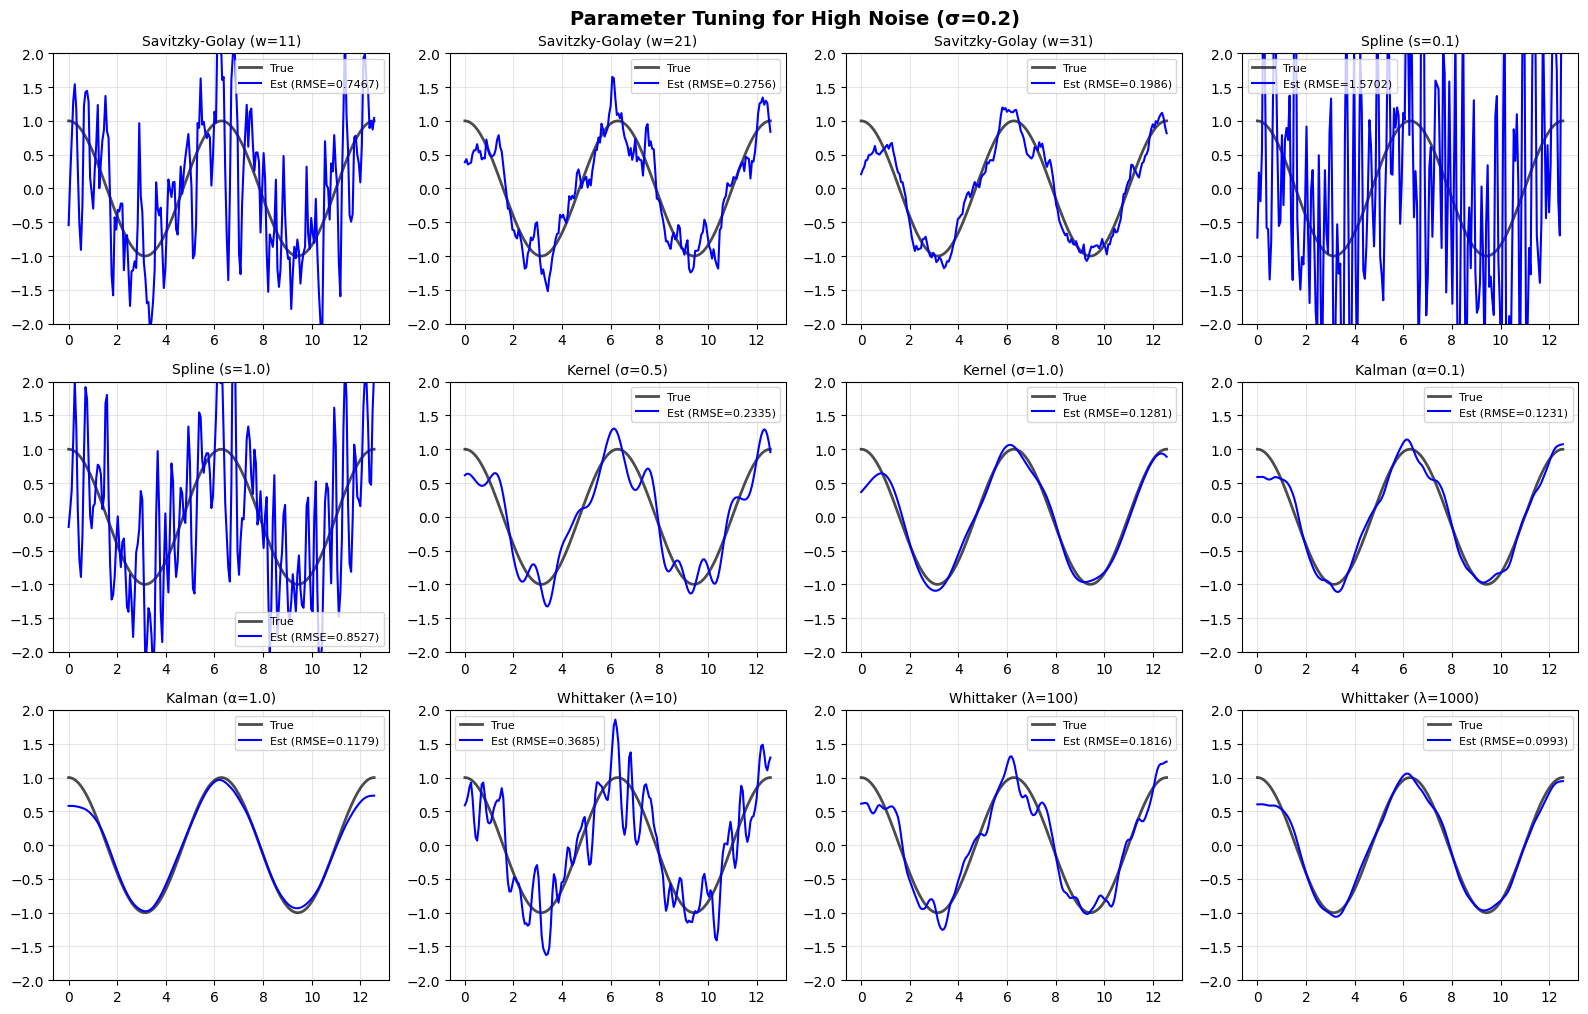

In [8]:
# High noise signal
x_noisy = noisy_signals["High noise (σ=0.2)"]

# Methods optimized for noisy data
noisy_methods = {
    "Savitzky-Golay (w=11)": ptdxdt.SavitzkyGolay(window_length=11, polyorder=3),
    "Savitzky-Golay (w=21)": ptdxdt.SavitzkyGolay(window_length=21, polyorder=3),
    "Savitzky-Golay (w=31)": ptdxdt.SavitzkyGolay(window_length=31, polyorder=3),
    "Spline (s=0.1)": ptdxdt.Spline(s=0.1),
    "Spline (s=1.0)": ptdxdt.Spline(s=1.0),
    "Kernel (σ=0.5)": ptdxdt.Kernel(sigma=0.5, lmbd=0.1),
    "Kernel (σ=1.0)": ptdxdt.Kernel(sigma=1.0, lmbd=0.1),
    "Kalman (α=0.1)": ptdxdt.Kalman(alpha=0.1),
    "Kalman (α=1.0)": ptdxdt.Kalman(alpha=1.0),
    "Whittaker (λ=10)": ptdxdt.Whittaker(lmbda=10.0),
    "Whittaker (λ=100)": ptdxdt.Whittaker(lmbda=100.0),
    "Whittaker (λ=1000)": ptdxdt.Whittaker(lmbda=1000.0),
}

# Compute and plot
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

for i, (name, method) in enumerate(noisy_methods.items()):
    ax = axes[i]
    dx = method.d(x_noisy, t)
    rmse = compute_rmse(dx, dx_true)
    
    ax.plot(t.numpy(), dx_true.numpy(), 'k-', linewidth=2, label='True', alpha=0.7)
    ax.plot(t.numpy(), dx.numpy(), 'b-', linewidth=1.5, label=f'Est (RMSE={rmse:.4f})')
    ax.set_title(name, fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-2, 2)

plt.tight_layout()
plt.suptitle('Parameter Tuning for High Noise (σ=0.2)', fontsize=14, fontweight='bold', y=1.01)
plt.show()

## 6. Smoothing Comparison

Some methods also provide smoothing capabilities. Let's compare them:

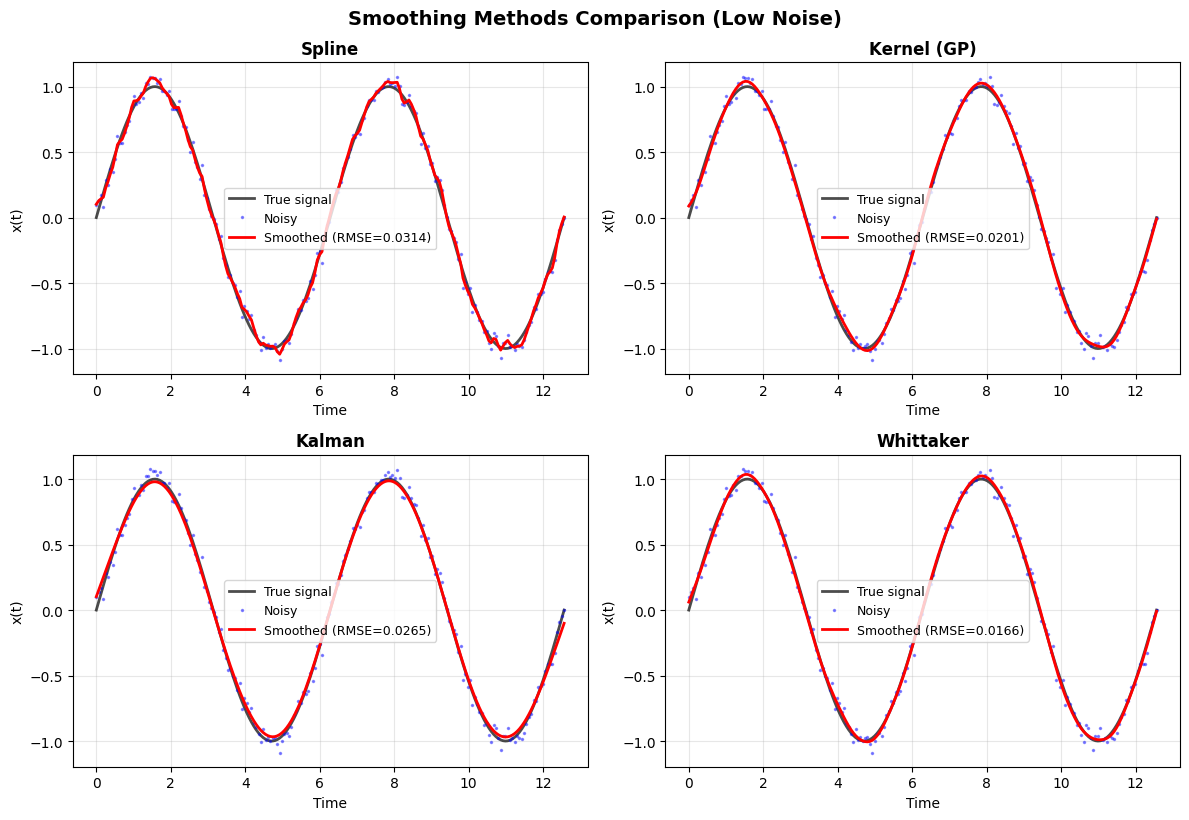

In [9]:
# Methods that support smoothing
smoothing_methods = {
    "Spline": ptdxdt.Spline(s=0.5),
    "Kernel (GP)": ptdxdt.Kernel(sigma=0.5, lmbd=0.05),
    "Kalman": ptdxdt.Kalman(alpha=0.5),
    "Whittaker": ptdxdt.Whittaker(lmbda=100.0),
}

x_noisy = noisy_signals["Low noise (σ=0.05)"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, (name, method) in zip(axes, smoothing_methods.items()):
    x_smooth = method.smooth(x_noisy, t)
    rmse = compute_rmse(x_smooth, x_true)
    
    ax.plot(t.numpy(), x_true.numpy(), 'k-', linewidth=2, label='True signal', alpha=0.7)
    ax.plot(t.numpy(), x_noisy.numpy(), 'b.', markersize=3, label='Noisy', alpha=0.4)
    ax.plot(t.numpy(), x_smooth.numpy(), 'r-', linewidth=2, label=f'Smoothed (RMSE={rmse:.4f})')
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Time')
    ax.set_ylabel('x(t)')

plt.tight_layout()
plt.suptitle('Smoothing Methods Comparison (Low Noise)', fontsize=14, fontweight='bold', y=1.02)
plt.show()

## 7. Computational Efficiency

Let's benchmark the forward and backward pass runtime for each method. Since all methods support PyTorch autograd, we can measure how fast they compute derivatives and gradients.

In [11]:
import time

def benchmark_method(method, x, t, n_runs=50, warmup=5):
    """Benchmark forward and backward pass for a method."""
    # Use requires_grad for backward pass
    x_grad = x.clone().requires_grad_(True)
    
    # Warmup runs
    for _ in range(warmup):
        dx = method.d(x_grad, t)
        loss = dx.sum()
        loss.backward()
        x_grad.grad = None
    
    # Benchmark forward pass
    forward_times = []
    for _ in range(n_runs):
        x_grad.grad = None
        start = time.perf_counter()
        dx = method.d(x_grad, t)
        torch.cuda.synchronize() if x.is_cuda else None
        forward_times.append(time.perf_counter() - start)
    
    # Benchmark backward pass
    backward_times = []
    for _ in range(n_runs):
        x_grad.grad = None
        dx = method.d(x_grad, t)
        loss = dx.sum()
        start = time.perf_counter()
        loss.backward()
        torch.cuda.synchronize() if x.is_cuda else None
        backward_times.append(time.perf_counter() - start)
    
    return {
        'forward_mean': np.mean(forward_times) * 1000,  # Convert to ms
        'forward_std': np.std(forward_times) * 1000,
        'backward_mean': np.mean(backward_times) * 1000,
        'backward_std': np.std(backward_times) * 1000,
    }

# Benchmark all methods
print("Benchmarking methods (this may take a moment)...")
print(f"Signal length: {n_points} points, {50} runs each\n")

benchmark_results = {}
for name, method in methods.items():
    try:
        results = benchmark_method(method, x_true, t)
        benchmark_results[name] = results
        print(f"✓ {name}")
    except Exception as e:
        print(f"✗ {name}: {e}")
        benchmark_results[name] = None

print("\nBenchmarking complete!")

Benchmarking methods (this may take a moment)...
Signal length: 200 points, 50 runs each

✓ Finite Difference (k=1)
✓ Finite Difference (k=2)
✓ Savitzky-Golay
✓ Spectral
✓ Spline (s=0.01)
✓ Kernel (GP)
✓ Kalman
✓ Whittaker

Benchmarking complete!


In [12]:
# Display timing results as a table
print("\n" + "="*90)
print("Computational Efficiency (Runtime in milliseconds)")
print("="*90)

header = f"{'Method':<30} {'Forward (ms)':<20} {'Backward (ms)':<20} {'Total (ms)':<15}"
print(header)
print("-"*90)

for name, result in benchmark_results.items():
    if result is not None:
        fwd = f"{result['forward_mean']:.3f} ± {result['forward_std']:.3f}"
        bwd = f"{result['backward_mean']:.3f} ± {result['backward_std']:.3f}"
        total = f"{result['forward_mean'] + result['backward_mean']:.3f}"
        print(f"{name:<30} {fwd:<20} {bwd:<20} {total:<15}")
    else:
        print(f"{name:<30} {'N/A':<20} {'N/A':<20} {'N/A':<15}")

print("="*90)


Computational Efficiency (Runtime in milliseconds)
Method                         Forward (ms)         Backward (ms)        Total (ms)     
------------------------------------------------------------------------------------------
Finite Difference (k=1)        0.052 ± 0.006        0.101 ± 0.017        0.154          
Finite Difference (k=2)        0.076 ± 0.018        0.113 ± 0.038        0.190          
Savitzky-Golay                 0.025 ± 0.001        0.041 ± 0.005        0.066          
Spectral                       0.039 ± 0.006        0.053 ± 0.010        0.093          
Spline (s=0.01)                2.941 ± 0.558        0.463 ± 0.067        3.404          
Kernel (GP)                    2.325 ± 0.449        0.176 ± 0.248        2.500          
Kalman                         11.073 ± 1.183       0.131 ± 0.022        11.203         
Whittaker                      1.705 ± 0.081        0.166 ± 0.015        1.871          


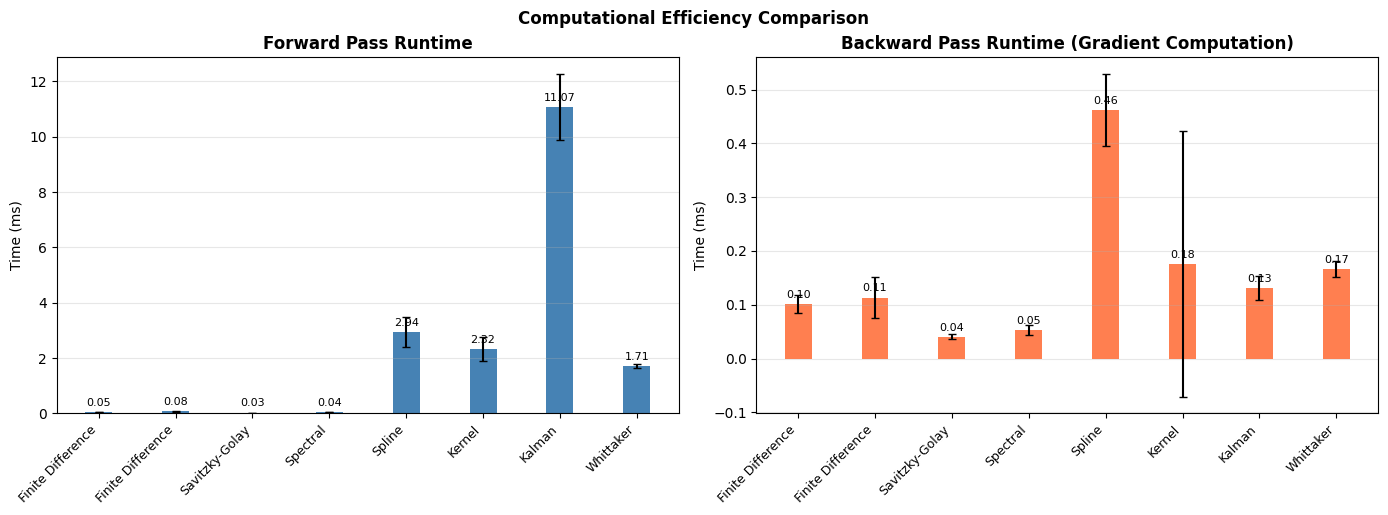

In [13]:
# Visualize timing results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

method_names_short = [m.split('(')[0].strip() for m in benchmark_results.keys()]
forward_times = [r['forward_mean'] if r else 0 for r in benchmark_results.values()]
backward_times = [r['backward_mean'] if r else 0 for r in benchmark_results.values()]
forward_stds = [r['forward_std'] if r else 0 for r in benchmark_results.values()]
backward_stds = [r['backward_std'] if r else 0 for r in benchmark_results.values()]

x_pos = np.arange(len(method_names_short))
width = 0.35

# Forward pass timing
ax1 = axes[0]
bars1 = ax1.bar(x_pos, forward_times, width, yerr=forward_stds, 
                color='steelblue', capsize=3, label='Forward')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(method_names_short, rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Time (ms)')
ax1.set_title('Forward Pass Runtime', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars1, forward_times):
    height = bar.get_height()
    ax1.annotate(f'{val:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

# Backward pass timing
ax2 = axes[1]
bars2 = ax2.bar(x_pos, backward_times, width, yerr=backward_stds,
                color='coral', capsize=3, label='Backward')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(method_names_short, rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Time (ms)')
ax2.set_title('Backward Pass Runtime (Gradient Computation)', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars2, backward_times):
    height = bar.get_height()
    ax2.annotate(f'{val:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.suptitle('Computational Efficiency Comparison', fontsize=12, fontweight='bold', y=1.02)
plt.show()

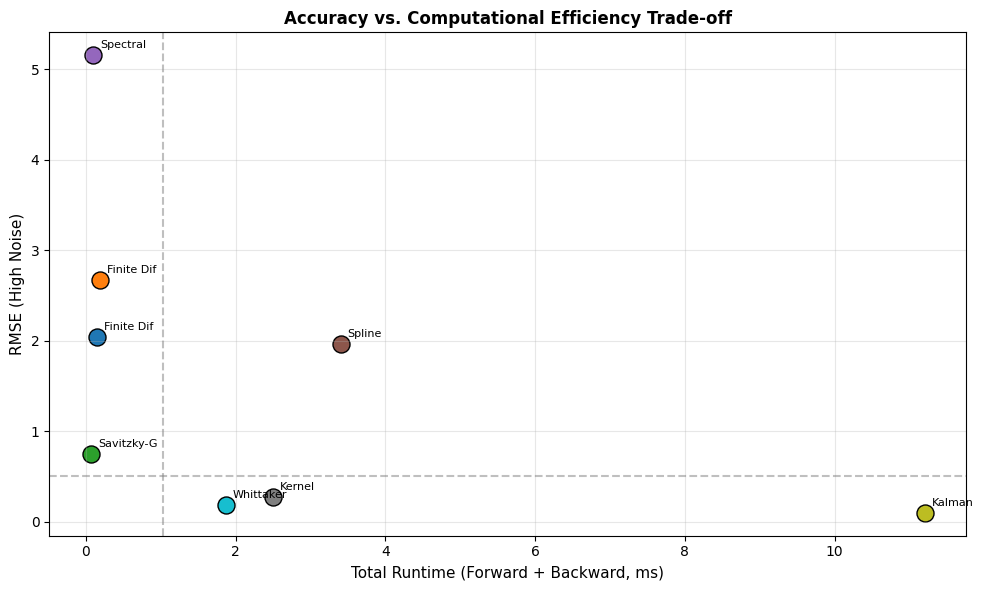


💡 Ideal methods are in the BOTTOM-LEFT corner (fast AND accurate)


In [14]:
# Combined efficiency vs accuracy plot
fig, ax = plt.subplots(figsize=(10, 6))

# Use high noise RMSE for accuracy comparison
noise_key = "High noise (σ=0.2)"

for i, (name, result) in enumerate(benchmark_results.items()):
    if result is not None and name in rmse_table[noise_key]:
        total_time = result['forward_mean'] + result['backward_mean']
        rmse = rmse_table[noise_key][name]
        
        ax.scatter(total_time, rmse, s=150, c=[colors[i]], 
                   label=name.split('(')[0].strip(), edgecolor='black', linewidth=1)
        ax.annotate(name.split('(')[0].strip()[:10], 
                   (total_time, rmse), 
                   xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.set_xlabel('Total Runtime (Forward + Backward, ms)', fontsize=11)
ax.set_ylabel('RMSE (High Noise)', fontsize=11)
ax.set_title('Accuracy vs. Computational Efficiency Trade-off', fontweight='bold', fontsize=12)
ax.grid(True, alpha=0.3)

# Add quadrants annotation
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=np.median([r['forward_mean'] + r['backward_mean'] 
                        for r in benchmark_results.values() if r]), 
           color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n💡 Ideal methods are in the BOTTOM-LEFT corner (fast AND accurate)")

## 8. Summary and Recommendations

Based on the comparisons above, here are some general guidelines:

### For Clean Data (No/Low Noise):
- **Spectral** method works extremely well for periodic signals
- **Finite Difference** is simple, effective, and **fastest**
- **Savitzky-Golay** with small window is accurate

### For Noisy Data:
- **Savitzky-Golay** with larger window provides good smoothing
- **Whittaker-Eilers** offers excellent global smoothing with tunable λ
- **Kernel (GP)** provides probabilistic smoothing
- **Kalman** is good for sequential/online estimation
- **Spline** with appropriate smoothing parameter

### Computational Efficiency:
- **Fastest**: Finite Difference, Savitzky-Golay (simple convolution operations)
- **Moderate**: Spectral (FFT-based), Kalman (sequential operations)
- **Slower**: Whittaker, Spline, Kernel (matrix operations/inversions)

### Best Trade-off (Accuracy vs Speed):
- **Kalman** and **Whittaker** offer the best balance of accuracy and efficiency for noisy data
- **Savitzky-Golay** is very fast with good accuracy when properly tuned

### Key Parameters to Tune:
- **Savitzky-Golay**: `window_length` (larger = smoother)
- **Whittaker**: `lmbda` (larger = smoother)
- **Spline**: `s` (larger = smoother)
- **Kernel**: `sigma` (kernel width) and `lmbd` (noise variance)
- **Kalman**: `alpha` (process noise)

In [15]:
# Final summary: Best method for each noise level
print("\n" + "="*60)
print("Best Methods by Noise Level (Lowest RMSE)")
print("="*60)

for noise_name, rmses in rmse_table.items():
    best_method = min(rmses.items(), key=lambda x: x[1])
    print(f"\n{noise_name}:")
    print(f"  Best: {best_method[0]} (RMSE = {best_method[1]:.6f})")
    
    # Top 3
    sorted_methods = sorted(rmses.items(), key=lambda x: x[1])
    print("  Top 3:")
    for i, (method, rmse) in enumerate(sorted_methods[:3], 1):
        print(f"    {i}. {method}: RMSE = {rmse:.6f}")

print("\n" + "="*60)


Best Methods by Noise Level (Lowest RMSE)

No noise:
  Best: Finite Difference (k=1) (RMSE = 0.000471)
  Top 3:
    1. Finite Difference (k=1): RMSE = 0.000471
    2. Spline (s=0.01): RMSE = 0.000472
    3. Whittaker: RMSE = 0.007004

Low noise (σ=0.05):
  Best: Kalman (RMSE = 0.058744)
  Top 3:
    1. Kalman: RMSE = 0.058744
    2. Whittaker: RMSE = 0.061624
    3. Kernel (GP): RMSE = 0.119996

High noise (σ=0.2):
  Best: Kalman (RMSE = 0.097021)
  Top 3:
    1. Kalman: RMSE = 0.097021
    2. Whittaker: RMSE = 0.181598
    3. Kernel (GP): RMSE = 0.276995

